[주의사항] <span style='color:red'>본 실습 코드들은 교육용으로 제공한 것입니다. 강사의 허락없는 상업적/비상업적 사용을 일체 금지합니다.</span> 

## 0. 실습 프로젝트 개요

우리나라 중소/중견 4개 샘플기업의 재무제표를 금감원 오픈다트로부터 다운로드 받아 재무분석과 DCF 기업가치를 계산해보는 프로젝트

참고: [온M&A-기업분석 금융공학 플랫폼](http://ohmybike.pythonanywhere.com)

* 오픈다트(https://opendart.fss.or.kr) 가입후 개인회원용 API 인증키 발급 필요 
* 파이썬 내장 DB인 SQLite3 데이터베이스 조회 위해 'DB Browser for SQLite' (https://sqlitebrowser.org) 설치 필요 

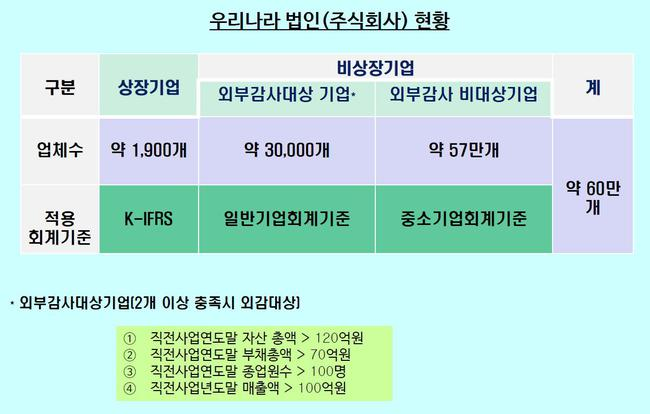

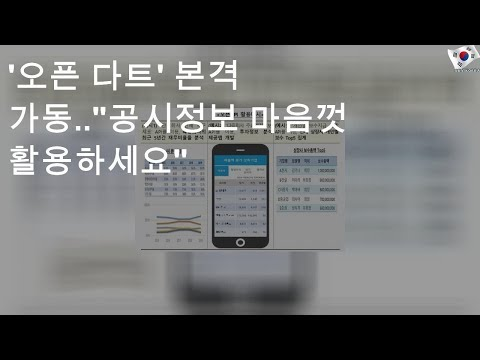

In [684]:
# 오픈다트 소개 동영상
from IPython.display import YouTubeVideo
YouTubeVideo('Loe4rXKehyU')

## 1. 오픈DART API Key

In [1]:
DB_NAME = 'dart.sqlite3'

In [2]:
# 금감원 오픈DART에서 받은 자신의 api key를 입력
api_key = '456881xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

In [3]:
import requests
from bs4 import BeautifulSoup

corp = '00108269' # 샘플기업(농심켈로그)

resp = requests.get('https://opendart.fss.or.kr/api/company.xml', \
                    params={'crtfc_key':api_key, 'corp_code':corp})

soup = BeautifulSoup(resp.text, 'lxml-xml')
status = soup.find('status').text

if status != '000':
    print(status, '  api_Key is NOT working )-:')
else:
    print(status, '  api_key is working ^^')

000   api_key is working ^^


In [4]:
from requests import get

ip = get("https://api64.ipify.org").text
print("My public IP address : ", ip)

My public IP address :  180.233.193.72


## 2. DB 입출력 함수 정의

In [5]:
def select_query(sql):    
    import sqlite3
    import pandas as pd
    
    conn = sqlite3.connect(DB_NAME)            
    df = pd.read_sql(sql, conn)
        
    conn.close()    
    return df

In [6]:
def save_to_table(df, table):    
   
    import sqlite3;

    conn = sqlite3.connect(DB_NAME)
    df.to_sql(table, conn, if_exists="append", index_label='id')

    conn.close()

## 3. 기업개황 테이블(COMPANY)

In [7]:
### 농심켈로그(00108269),면사랑(00301477),아성다이소(00411835),토요코인코리아(00585583)
KELLOGG = '00108269' # 제조업
NOODLE = '00301477' # 제조업
DAISO = '00411835' # 도소매업
TOYOKO = '00585583' # 숙박업

In [8]:
def target_name(code):
    if code == '00108269':
        return 'KELLOGG'
    if code == '00301477':
        return 'NOODLE'
    elif code == '00411835':
        return 'DAISO'
    elif code  == '00585583':
        return 'TOYOKO'
    else:
        return None

In [9]:
### COMPANY 테이블 생성
import pandas as pd
import requests
from bs4 import BeautifulSoup
import pdb
# import random

cols = ["corp_code", "corp_name", "corp_name_eng", "stock_name", "stock_code", "ceo_nm", 
        "corp_cls", "jurir_no", "bizr_no", "adres", "hm_url","ir_url", 
        "phn_no", "fax_no", "induty_code", "est_dt", "acc_mt"]
rows = []

corps = [KELLOGG, NOODLE, DAISO, TOYOKO]

for i, corp in enumerate(corps):    
    
    resp = requests.get('https://opendart.fss.or.kr/api/company.xml', params={'crtfc_key':api_key, 'corp_code':corp})
              
    soup = BeautifulSoup(resp.text, 'lxml-xml')
    
    results = []
    
    for element in cols[:]:         
        if soup is not None and soup.find(element) is not None:            
            results.append(soup.find(element).text)
        
    if len(results) > 0:    
        rows.append({cols[i]: results[i] for i, _ in enumerate(cols)})   

df = pd.DataFrame(rows, columns=cols)
save_to_table(df, 'COMPANY')

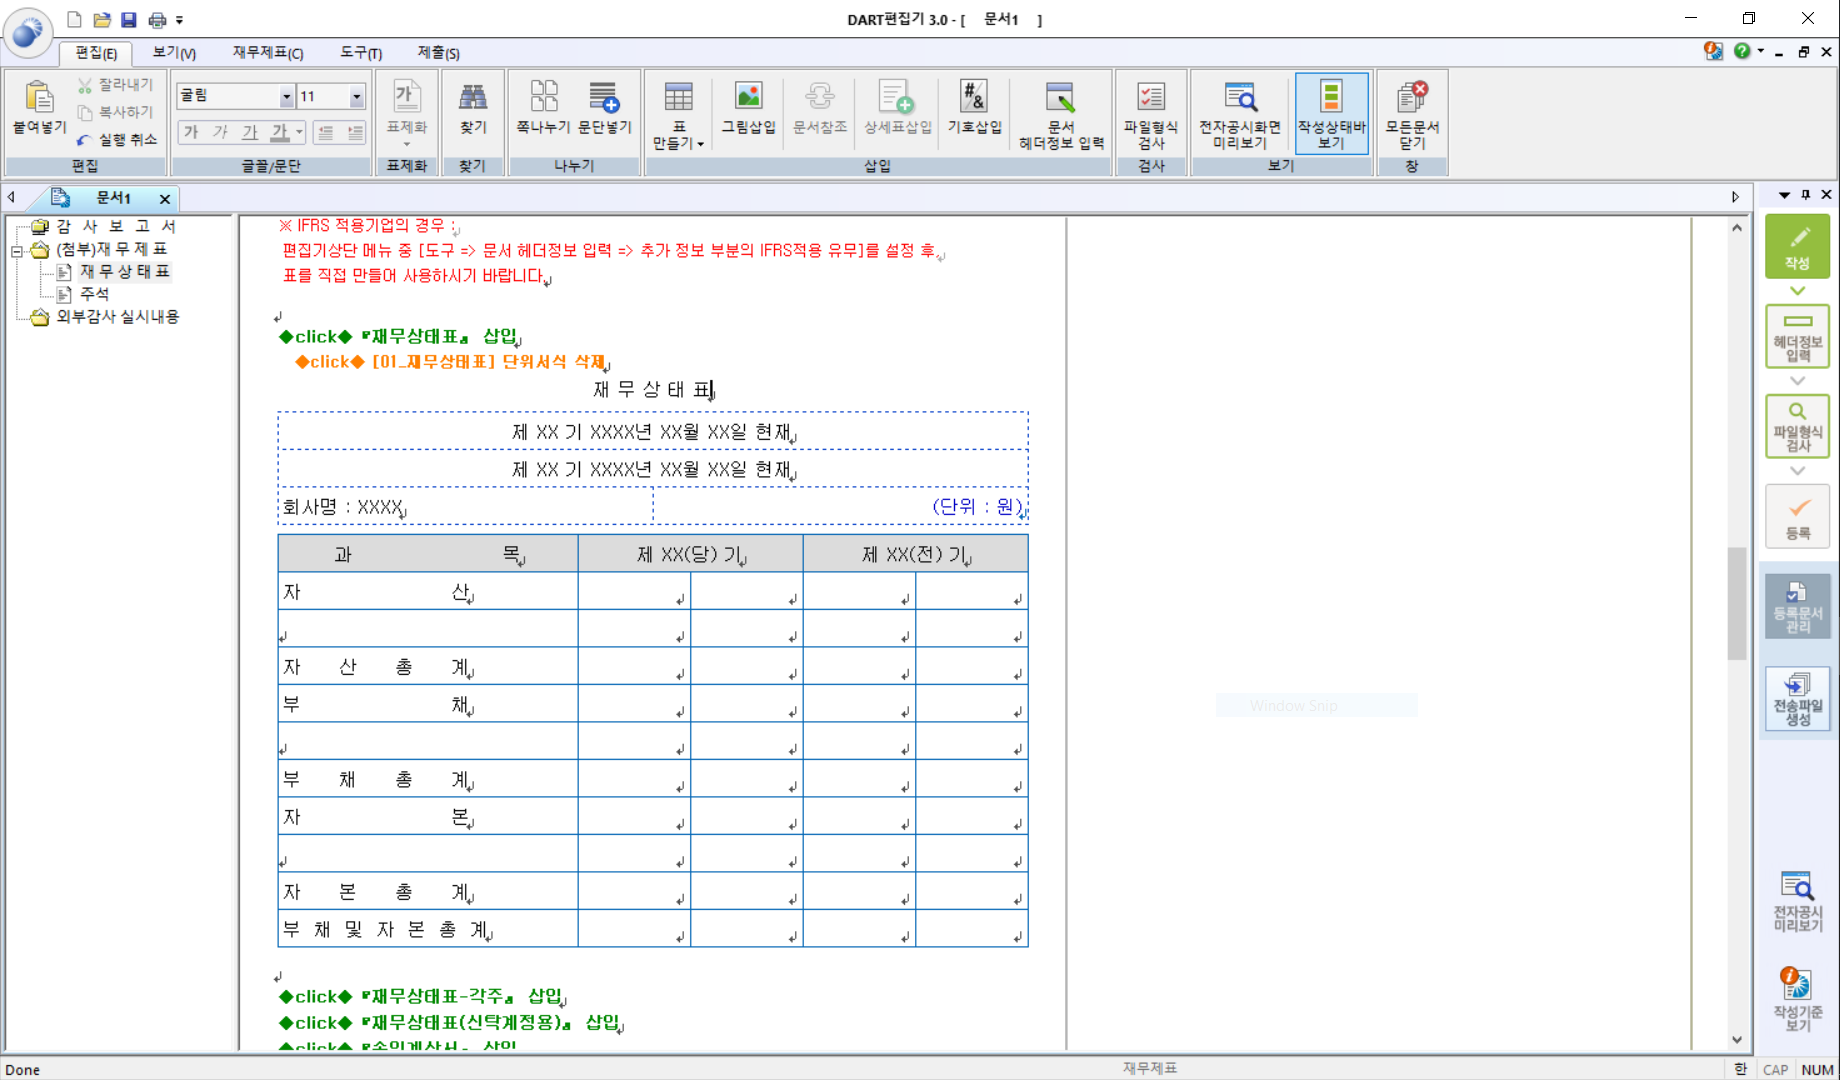

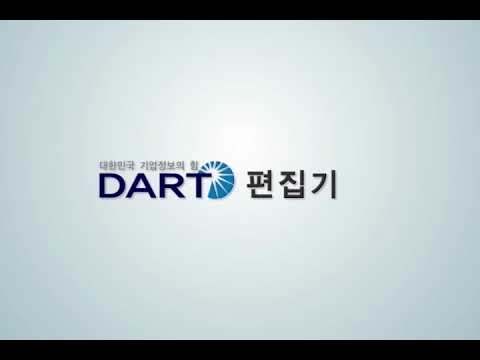

In [10]:
# 다트편집기 소개 동영상
from IPython.display import YouTubeVideo
YouTubeVideo('Zt0gIglxbQM')

## 4. 보고서 접수번호 테이블(REPORT)

In [11]:
### 비상장기업 감사보고서 접수번호 얻는 합수
def get_rcept_no(corp_code):
    import requests
    from bs4 import BeautifulSoup
    import pandas as pd
    
    BEGIN = '20140101'
    END   = '20231231'
    
    resp = requests.get('https://opendart.fss.or.kr/api/list.xml', 
                        params={'crtfc_key':api_key, 'corp_code':corp_code, 'pblntf_detail_ty':'F001',
                        'bgn_de':BEGIN, 'end_de':END}) # F001: 감사보고서       
    
    soup = BeautifulSoup(resp.text, 'lxml-xml')             
   
    tags = soup.find_all('list')    
    
    cols = ['corp_cls', 'rcept_no', 'report_nm', 'flr_nm']
    rows = []
    
    for tag in tags[:]:
        results = []
        
        for element in cols[:]:
#             print(tag.find(element).text)
            if tag is not None and tag.find(element) is not None:
                results.append(tag.find(element).text)
           
        rows.append({cols[i]:results[i] for i, _ in enumerate(cols)})
        
    # if corp_code == '00301477':
    #     print(rows)
    
    del_mode = False # 기재정정시 이전보고서 삭제 목적

    for i, row in enumerate(rows[:]):
        # 보고서명에 [첨부추가], [첨부정정]이 포함된 경우를 제외 
        if row['report_nm'].find('첨부') != -1:                        
            rows.remove(row)
            continue       
        elif row['report_nm'].find('기재정정') != -1:
            del_mode = True
            continue
        
        if del_mode:
            rows.remove(row)
            del_mode = False   
    
    # if len(rows) > 0: 
    #     print(rows)
                
    return rows

In [12]:
# 실제 로직
import pandas as pd
import random

df = select_query('select * from COMPANY')

rows = []
cols = ['corp_code','corp_cls','fas','year','month','acc_mt','rcept_no','report_nm','flr_nm']

for i, r in df.iterrows():
    temp = get_rcept_no(r['corp_code'])
    
    for t in temp:                
        rcept_no = t['rcept_no']
        report_nm = t['report_nm']      
    
        rows.append({'corp_code':r['corp_code'], 'corp_cls':t['corp_cls'], 'fas':'GAAP', \
                     'year':report_nm[-8:-4], 'month':report_nm[-3:-1], 'acc_mt':r['acc_mt'], \
                       'rcept_no':rcept_no, 'report_nm':report_nm, 'flr_nm':t['flr_nm']})

df = pd.DataFrame(rows, columns=cols)
# print(df)
save_to_table(df, 'REPORT')

## [Quiz 3]

1. 오픈다트 사이트에 접속하여 본인의 계정으로 호출한 총 호출건수와 서비스별 호출건수를 알아보세요.

2. 자신의 API key 호출이 정상적으로 작동되고 있는지 테스트하는 코드를 작성해 보세요. (원문다운로드(document.xml) 호출과 농심켈로그 2022년 감사보고서 접수번호(rcept_no) 이용)

3. COMPANY 테이블 중 아성다이소와 토요코인 데이터를 pandas 데이터프레임으로 로딩하여 화면에 출력하는 코드를 작성하세요.
select_query("select * from COMPANY where corp_code in ('', '')")

## 5. 감사보고서 파싱하여 저장(FS)

In [13]:
# notepad++ 설치 필요

In [14]:
# https://opendart.fss.or.kr/api/document.xml?crtfc_key=45688185cb834c3c13d22ba42a1ba654ad30e628&rcept_no=20160404001388

# 감사보고서 HTML 리턴 함수
def get_audit_soup(rcept_no):
    import requests
    from io import BytesIO
    from zipfile import ZipFile
    from bs4 import BeautifulSoup
    import warnings
    
    # 경고메세지 끄기
    warnings.filterwarnings(action='ignore')

    # 다시 출력하게 하기
    # warnings.filterwarnings(action='default')

    # OpenDART에서 Zipfile 받아와 객체에 저장하기       
    resp = requests.get('https://opendart.fss.or.kr/api/document.xml', params={'crtfc_key':api_key, 'rcept_no':rcept_no})
    
    zipfile_bytes = resp.content
    zipfile_obj = ZipFile(BytesIO(zipfile_bytes))

    # 압축을 풀어서 XML File을 string으로 담기
    xmlfile_objs = {name.strip('/'): zipfile_obj.read(name) for name in zipfile_obj.namelist()}        
    xml_str = xmlfile_objs[rcept_no+'_00760.xml'] # 00760: 감사보고서
    soup = BeautifulSoup(xml_str, 'lxml')

    return soup

In [15]:
def make_amt(amt):
    import re    
    
    m = re.compile('[0-9|\()]').findall(amt)
    m = ''.join(m) # join 함수는 매개변수로 들어온 리스트에 있는 요소 하나하나를 합쳐서 하나의 문자열로 바꾸어 반환
    m = m.replace('()', '')
    m = m.replace('(','-').replace(')','')

    if m == '':
        return 0
    else:
        return int(m)

In [16]:
def parse_report(corp_code, year, month, acc_mt, rcept_no):
    import pandas as pd
    # import requests
    import re

    print(corp_code, year, month, rcept_no)  
    soup = get_audit_soup(rcept_no)

    # acode가 숫자4자리 이상인 <te> 구문만 선택 (자본변동표를 제외시키기 위함)    
    tags = soup.findAll('te', {'acode': re.compile('^[0-9]{4,}$')})         
    # paragraphs = soup.findAll('p')
        
      
    # 재무상태표, 손익계산서, 현금흐름표        
    cols = ['corp_code','year','month','acc_mt','rcept_no','fas','type','acct_nm','acct_cd','acct_lev','amt','prev_amt']
    results = ['' for i in range(len(cols))]
    rows = []
      
    prev_alevel = ''
    prev_acct = ''        
    results[0] = corp_code
    results[1] = year
    results[2] = month   
    results[3] = acc_mt   
    results[4] = rcept_no           
    results[5] = 'GAAP' # 일반기업회계기준

    ALLOW_ACCT = ['매출채권','단기대여금','미수금','미수수익','선급금','장기대여금','장기외상매출금', '대출금']
    DEP_ACCT = ['건물','시설장치','기계장치','차량운반구','구축물','의료장비','공구와기구','비품','시설장치','연구용장비',\
                '연구용기자재','금형','기타의유형자산']
    
    for table in soup.find_all('table-group', aclass=['PBS-2:A', 'PIS-2:A', 'PCF-I:A']): 

        if table['aclass'] == 'PBS-2:A': results[6] = 'BS'
        elif table['aclass'] == 'PIS-2:A': results[6] = 'IS'
        elif table['aclass'] == 'PCF-I:A': results[6] = 'CF'
        
        for tag in table.find_all('te', {'acode': re.compile('^[0-9]{4,}$')}):                               
               
            if tag['adelim'] == '0':
                
                idx = tag.text.find('.')
                if idx != -1:                    
                    tmp = tag.text[idx:]
                else:
                    tmp = tag.text
                
                idx = tmp.find('(주')
                if idx != -1:                    
                    tmp = tmp[:idx]
                    
                idx = tmp.find('<주')
                if idx != -1:                    
                    tmp = tmp[:idx]
                                                    
                tmp = tmp.replace('(손실)','').replace('(증가)','').replace('(감소)','')
                
                tmp = re.compile('[가-힣]+').findall(tmp)            
                tmp = ''.join(tmp)
                
                if tmp == '계': # 재무제표상 소계를 낸 라인의 경우 스킵
                    continue
                
                if tmp == '대손충당금' and prev_acct in ALLOW_ACCT:
                    tmp = prev_acct+tmp
                elif tmp == '감가상각누계액' and prev_acct in DEP_ACCT:
                    tmp = prev_acct+tmp

                results[7] = tmp
                results[8] = tag['acode']
                results[9] = tag['alevel']
                prev_alevel = tag['alevel']
                prev_acct = tmp
            
            else:
                if table['aclass'] == 'PBS-2:A': # 재무상태표
                    if prev_alevel in ('0','1') and tag['adelim'] == '2':
                        results[10] = make_amt(tag.text)                                
                    elif prev_alevel == '2' and tag['adelim'] == '1':
                        results[10] = make_amt(tag.text)                                    
                    elif prev_alevel in ('0','1') and tag['adelim'] == '4':
                        results[11] = make_amt(tag.text)                
                        if results[7] not in ['자산', '부채', '자본']:
                            rows.append({cols[i]:results[i] for i, _ in enumerate(cols)})                                            
                        prev_alevel = ''
                    elif prev_alevel == '2' and tag['adelim'] == '3':
                        results[11] = make_amt(tag.text)                
                        if results[7] not in ['자산', '부채', '자본']:
                            rows.append({cols[i]:results[i] for i, _ in enumerate(cols)})                            
                        prev_alevel = ''             
                else: # 손익계산서('PIS-2:A'), 현금흐름표('PCF-I:A')
                    if prev_alevel == '0' and tag['adelim'] == '2':
                        results[10] = make_amt(tag.text)                                
                    elif prev_alevel in ('1','2') and tag['adelim'] == '1':
                        results[10] = make_amt(tag.text)                                    
                    elif prev_alevel == '0' and tag['adelim'] == '4':
                        results[11] = make_amt(tag.text)                
                        rows.append({cols[i]:results[i] for i, _ in enumerate(cols)})                                            
                        prev_alevel = ''
                    elif prev_alevel in ('1','2') and tag['adelim'] == '3':
                        results[11] = make_amt(tag.text)                
                        rows.append({cols[i]:results[i] for i, _ in enumerate(cols)})                            
                        prev_alevel = ''                
       
    df_fs = pd.DataFrame(rows, columns=cols)    
    
    return df_fs

In [17]:
# 메인 코드
import random
import pandas as pd

df = select_query('select * from REPORT')

df_fs = pd.DataFrame()

for i, row in df.iterrows():
    tmp = parse_report(row['corp_code'], row['year'], row['month'], row['acc_mt'], row['rcept_no'])
    if tmp is not None:      
        df_fs = pd.concat([df_fs, tmp], ignore_index=True)
        
save_to_table(df_fs, 'FS')

00108269 2022 12 20230320001108
00108269 2021 12 20220331000105
00108269 2020 12 20210330000796
00108269 2019 12 20200330003768
00108269 2018 12 20190402000409
00108269 2017 12 20180404000561
00108269 2016 12 20170404001467
00108269 2015 12 20160404001388
00108269 2014 12 20150331000318
00108269 2013 12 20140327000710
00301477 2022 12 20230330000644
00301477 2021 12 20220401000723
00301477 2020 12 20210507000611
00301477 2019 12 20200402001109
00301477 2018 12 20190410000818
00301477 2017 12 20180410001133
00301477 2016 12 20170410001945
00301477 2015 12 20160331002179
00301477 2014 12 20150402001543
00411835 2022 12 20230412000331
00411835 2021 12 20220413000618
00411835 2020 12 20210414000481
00411835 2019 12 20200410000894
00411835 2018 12 20190402002448
00411835 2017 12 20180413001734
00411835 2016 12 20170331000917
00411835 2015 12 20160411002284
00411835 2014 12 20150401001558
00411835 2013 12 20140410000887
00585583 2022 12 20230413000799
00585583 2021 12 20220422000783
00585583

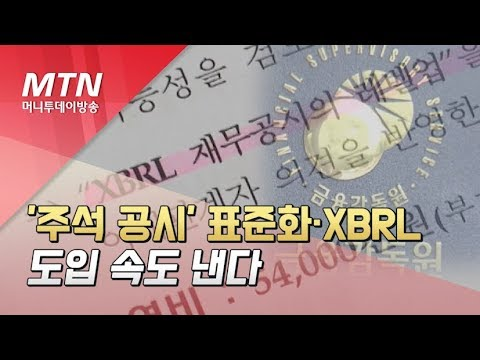

In [18]:
# 주석공시 표준화와 XBRL
from IPython.display import YouTubeVideo
YouTubeVideo('XpMmVpplaU8')

## 6. 재무분석 수행(ANLS)
(CFA/FRM Schweser 교재 참고)

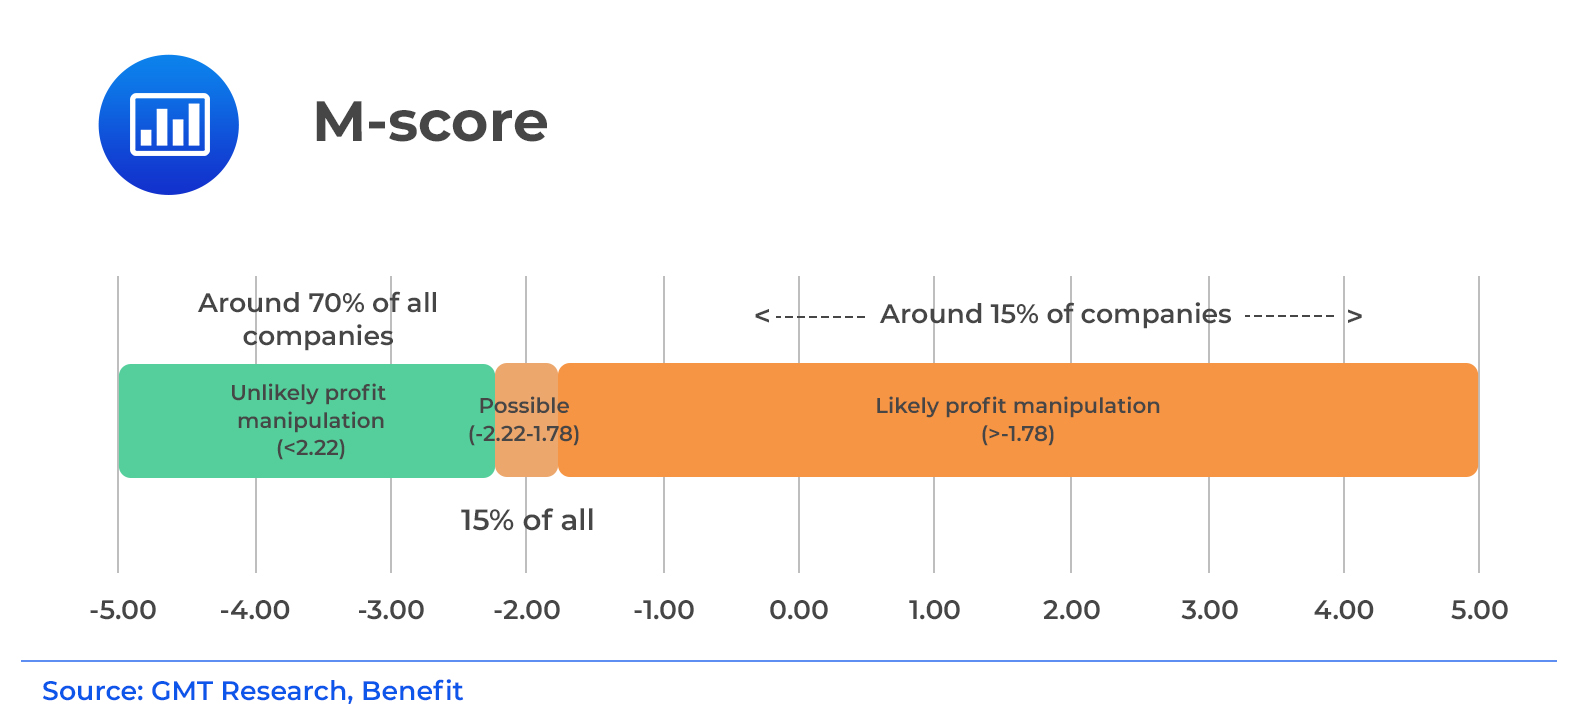

### 재무제표 신뢰도(Beneish M-score, 1999) -> detect financial fraud

Beneish's M-Score is a mathematical model that uses eight financial ratios weighted by coefficients to identify whether a company has manipulated its profits. It was created by Professor Messod Beneish who published a paper in June 1999 called "The Detection of Earnings Manipulation".

* Days Sales in Receivables Index (DSRI): 매출에서 매출채권이 차지하는 비중이 작년보다 늘어난 정도, 매출채권 과대계상
    - $\text{DSRI} = \dfrac{\text{Receivables}_t / \text{Sales}_t}{\text{Receivables}_{t-1} / \text{Sales}_{t-1}}$

The days' sales in accounts receivable can be calculated as follows: the number of days in the year (use 360 or 365) divided by the accounts receivable turnover ratio during a past year.

* Gross Margin Index (GMI): 매출 대비 매출총이익 비율이 올해 줄어든 정도, 매출원가 과대계상
    - $\text{GMI} = \dfrac{(\text{Sales}_{t-1} - \text{COGS}_{t-1}) / \text{Sales}_{t-1}}{ (\text{Sales}_t - \text{COGS}_t) / \text{Sales}_t}$

When this ratio is greater than 1, the gross margin has deteriorated. A firm with declining margins is more likely to manipulate earnings.

* Asset Quality Index (AQI): 자산 중 공정가치를 의심할만한 자산들이 증가할 경우
    - $ \text{AQI} = \dfrac{1 - (\text{Current Assets}_t + \text{PP&E}_t + \text{Securities}_t) / \text{Total Assets}_t}{1 - (\text{Current Assets}_{t-1} + \text{PP&E}_{t-1} + \text{Securities}_{t-1}) / \text{Total Assets}_{t-1}} $

 It indicates the amount of total assets that are less certain to be ultimately realized, identified as asset quality.

* Sales Growth Index (SGI): 매출이 꾸준히 성장하는 회사의 경우 그 성장세가 꺾였을때 어떻게든 그것을 감추려고 재무제표를 조작
    - $ \text{SGI} = \dfrac{\text{Sales}_t}{\text{Sales}_{t-1}} $

* Depreciation Index (DEPI): 갑자기 감가상각비가 줄었다면, 감가상각비 계산 가정을 조작하여 회사의 비용을 낮춘 조작일 수 있음
    - $ \text{DEPI} = \dfrac{\text{Depreciation}_{t-1}/ (\text{PP&E}_{t-1} + \text{Depreciation}_{t-1})}  {\text{Depreciation}_t / (\text{PP&E}_t + \text{Depreciation}_t)} $

* Sales General and Administrative Expenses Index (SGAI): 판관비의 비중이 늘어났다는 것은 그만큼 경영 및 마케팅이 비효율적
    - $ \text{SGAI} = \dfrac{\text{SG&A Expense}_t / \text{Sales}_t} {\text{SG&A Expense}_{t-1} / \text{Sales}_{t-1}} $

* Leverage Index (LVGI): 총 자산에 비해 부채가 클 수록 회계부정을 의심해야 한다
    - $ \text{LVGI} = \dfrac{(\text{Current Liabilities}_t + \text{Total Long Term Debt}_t) / \text{Total Assets}_t} {(\text{Current Liabilities}_{t-1} + \text{Total Long Term Debt}_{t-1}) / \text{Total Assets}_{t-1}} $

* Total Accruals to Total Assets (TATA): 총 자산에 비해 비현금이익의 비중이 클수록 회계부정을 의심해야 한다
    - $ \text{TATA} = \dfrac{\text{Income from Continuing Operations}_t - \text{Cash Flows from Operations}_t} {\text{Total Assets}_t} $


The formula to calculate the M-score is:
$$ \text{M-score} = −4.84 + 0.92 \text{DSRI} + 0.528 \text{GMI} + 0.404 \text{AQI} + 0.892 \text{SGI} + 0.115 \text{DEPI} − 0.172 \text{SGAI} − 0.327 \text{LVGI} + 4.697 \text{TATA} $$


### Financial Ratios

* activity ratios
    
    - $ \text{total asset turnover} = \dfrac{\text{revenue}} {\text{average total assets}} $
      
* liquidity ratios
    - $ \text{current ratio} = \dfrac{\text{current assets}} {\text{current liabilites}} $    
 
* solvency ratios
    - $ \text{debt-to-equity} = \dfrac{\text{total debt}} {\text{total sharehoilders' equity}} $
       
    - $ \text{financial leverage} = \dfrac{\text{average total assets}} {\text{average total equity}} $
    
    - $ \text{interest coverage} = \dfrac{\text{EBIT}} {\text{interest payments}} $
       
* profitability ratios
     - $ \text{net profit margin} = \dfrac{\text{net income}} {\text{revenue}} $
     
     - $ \text{gross profit margin} = \dfrac{\text{gross profit}} {\text{revenue}} $
     
     - $ \text{operating profit margin} = \dfrac{\text{operating income}} {\text{revenue}} $     

     - $ \text{return on equity} = \dfrac{\text{net income}} {\text{average total equity}} $    


### Free Cash Flow

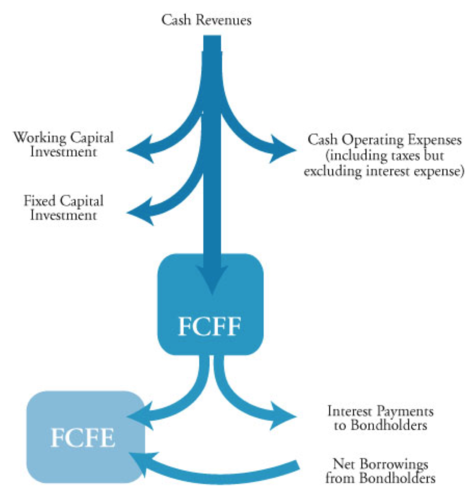

* Free Cash Flow to the Firm: unlevered FCF, 채권자와 주주 몫
    - $ \text{FCFF}_1 = \text{[EBIT×(1-tax rate)] + depreciation - working capital investment - fixed capital investment}$
    - $ \text{FCFF}_2 = \text{[EBITDA×(1-tax rate)] + depreciation×tax rate - working capital investment - fixed capital investment}$
    - $ \text{FCFF}_3 = \text{cash flow from operations + [interest×(1-tax rate)] - fixed capital investment} $
    - $ \text{FCFF}_4 = \text{net income + noncash charges - working capital investment + [interest×(1-tax rate)] - fixed capital investment} $


* Free Cash Flow to Equity: levered FCF, 주주 몫
    - $ \text{FCFE}_1 = \text{FCFF - [interest×(1-tax rate)] + net borrowing} $
    - $ \text{FCFE}_2 = \text{cash flow from operations - fixed capital investment + net borrowing} $
    - $ \text{FCFE}_3 = \text{net income + noncash charges - working captital investment - fixed capital investment  + net borrowing} $

### 부도와의 거리(Altman z-score) -> detect corporate failure

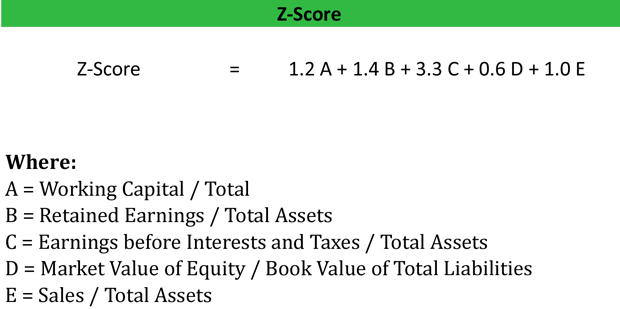

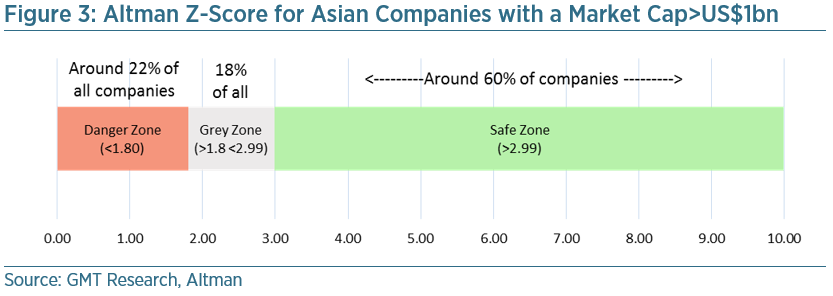

In [19]:
def acct_val(df, acct, prev):
    val = 0

    for a in acct:   
        if a == '당기순이익' or a == '당기순손실': # 당기순이익(손실)은 IS, CF 둘다 있기 때문에 하나만 선택
            t = df[df['type']=='IS']
        t = df['acct_nm']#.replace(' ','')
        
        if prev:
            v = sum(map(int, df[t==a].prev_amt.values)) 
            val = val + v                
        else:                
            v = sum(map(int, df[t==a].amt.values))
            val = val + v

    return val

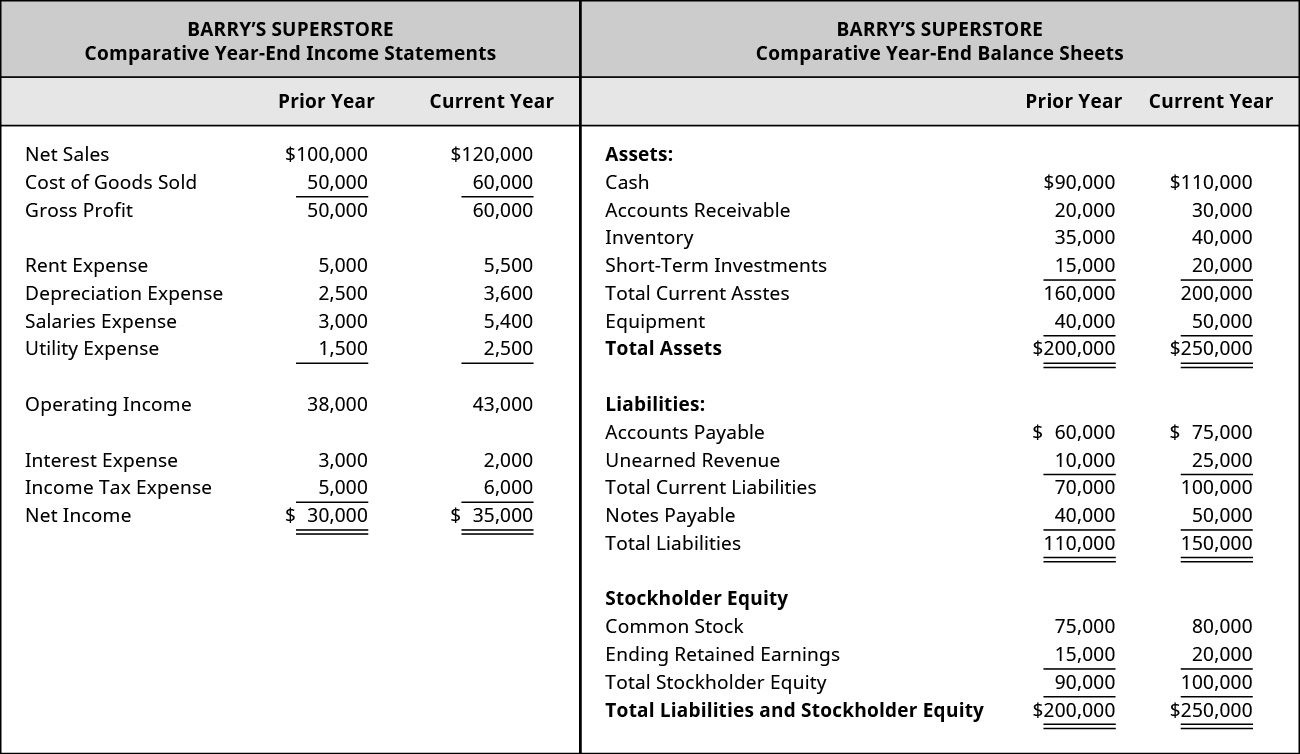

In [20]:
import pandas as pd

df_report = select_query('select * from REPORT')

cols = ['corp_code','year','month','rcept_no',
        # M-score
        'dsri', 'gmi', 'aqi', 'sgi', 'depi', 'sgai', 'lvgi', 'tata', 'm_score',
        # activity ratios
        'total_asset_turnover', 
        # liquidity ratios
        'current_ratio', 
        # solvency ratios
        'debt_to_equity', 'financial_leverage', 'interest_coverage',  
        # profitability ratios
        'net_profit_margin', 'gross_profit_margin', 'operating_profit_margin', 'return_on_equity',
        # FCF
        'ebit', 'ebitda', 'fcff', 'fcfe',
        # z-score
        'x1', 'x2', 'x3', 'x4', 'x5', 'z_score']
rows = []

SALES = ['매출액','수익(매출액)','영업수익']
RECEIVABLES = ['매출채권','매출채권및기타채권','분양미수금']
PPE = ['유형자산','무형자산']
CGS = ['매출원가','매출원가액']
SGA = ['판매관리비','판매비와관리비','영업비용']
DNA = ['감가상각비', '감가상각액', '무형자산상각비','무형자산상각액']
# NON_CASH_CHARGE = DNA + ['대손충당금']
TAX = ['법인세','법인세비용']
NET_INCOME = ['당기순이익']
NET_LOSS = ['당기순손실']
BORROWING = ['차입금','장기차입금','단기차입금','유동성장기부채']
BORROWED = ['대여금','단기대여금','장기대여금']
INT_COST = ['이자비용','금융비용']
EBT = ['법인세차감전순이익','법인세비용차감전순이익']
FCINV = ['건물의취득','기계장치의취득','차량운반구의취득','의료장비의취득','비품의취득','시설장치의취득','건설중인자산의취득'] 

for i, r in df_report.iterrows():
    results = []
    
    # print(r['corp_code'], r['year'], r['month'], r['rcept_no'])    
    df = select_query("select * from FS where corp_code='"+r['corp_code']+"' and year='"+r['year']+"' \
            and month='"+r['month']+"'")

    if len(df) <= 0:
        continue
    else:      
        corp_code = r['corp_code']
        year = r['year']
        month = r['month']
        rcept_no = r['rcept_no']
    #        
    #     Beneish M-score
    # 
    try: # Days Sales in Receivables Index
        dsri = (acct_val(df,RECEIVABLES,0)/acct_val(df,SALES,0)) / (acct_val(df,RECEIVABLES,1)/acct_val(df,SALES,1))
    except: dsri = None
    else: dsri = round(dsri, 4)   

    try: # Gross Margin Index
        gmi = ((acct_val(df,SALES,1)-acct_val(df,CGS,1)) / acct_val(df,SALES,1)) \
            / ((acct_val(df,SALES,0)-acct_val(df,CGS,0)) / acct_val(df,SALES,0))
    except: gmi = None 
    else: gmi = round(gmi, 4)         

    try: # Asset Quality Index
        aqi = (1 - ((acct_val(df,['유동자산'],0)+acct_val(df,PPE,0)) / acct_val(df,['자산총계'],0))) \
            / (1 - ((acct_val(df,['유동자산'],1)+acct_val(df,PPE,1)) / acct_val(df,['자산총계'],1)))        
    except: aqi = None
    else: aqi = round(aqi, 4)   

    try: # Sales Growth Index
        sgi = acct_val(df,SALES,0) / acct_val(df,SALES,1)
    except: sgi = None 
    else: sgi = round(sgi, 4)    

    try: # Depreciation Index
        depi = (acct_val(df,DNA,0) / (acct_val(df,PPE,0)+acct_val(df,DNA,0))) \
            / (acct_val(df,DNA,1) / (acct_val(df,PPE,1)+acct_val(df,DNA,1)))
    except: depi = None 
    else: depi = round(depi, 4)  

    try: # Sales General and Administrative Expenses Index
        sgai = (acct_val(df,SGA,0)/acct_val(df,SALES,0)) / (acct_val(df,SGA,1)/acct_val(df,SALES,1))
    except: sgai = None 
    else: sgai = round(sgai, 4)    

    try: # Leverage Index        
        lvgi = ((acct_val(df,['유동부채'],0)+acct_val(df,['비유동부채'],0)-acct_val(df,['매입채무'],0)) / acct_val(df,['자산총계'],0)) \
            / ((acct_val(df,['유동부채'],1)+acct_val(df,['비유동부채'],1)-acct_val(df,['매입채무'],1)) / acct_val(df,['자산총계'],1))
    except: lvgi = None 
    else: lvgi = round(lvgi, 4)   

    try: # Total Accruals to Total Assets
        tata = (acct_val(df,NET_INCOME,0) + acct_val(df,NET_LOSS,0)-acct_val(df,['영업활동으로인한현금흐름'],0)) \
            / (acct_val(df,['자산총계'],0))
    except: tata = None 
    else: tata = round(tata, 4)    

    try: # Manipulation score
         m_score = -4.84+0.92*dsri+0.528*gmi+0.404*aqi+0.892*sgi+0.115*depi-0.172*sgai-0.327*lvgi+4.697*tata
    except: m_score = None 
    else: m_score = round(m_score, 4)    
    # 
    #     financial ratios
    # 
    
    # activity ratios    
    try:
        total_asset_turnover = acct_val(df,SALES,0) / (acct_val(df,['자산총계'],0)*0.5+acct_val(df,['자산총계'],1)*0.5)
    except: total_asset_turnover = None 
    else: total_asset_turnover = round(total_asset_turnover, 4)   

    # liquidity ratios
    try:
        current_ratio = acct_val(df,['유동자산'],0) / acct_val(df,['유동부채'],0)
    except: current_ratio = None 
    else: current_ratio = round(current_ratio, 4)   

    # solvency ratios
    try:
        debt_to_equity = acct_val(df,['부채총계'],0) / acct_val(df,['자본총계'],0)
    except: debt_to_equity = None
    else: debt_to_equity = round(debt_to_equity, 4)    
    
    try:
        financial_leverage = (acct_val(df,['자산총계'],0)*0.5 + acct_val(df,['자산총계'],1)*0.5) \
        / (acct_val(df, ['자본총계'],0)*0.5 + acct_val(df,['자본총계'],1)*0.5)
    except: financial_leverage = None
    else: financial_leverage = round(financial_leverage, 4)    

    try:
        interest_coverage = (acct_val(df,EBT,0)+acct_val(df,INT_COST,0)) / acct_val(df,INT_COST,0)
    except: interest_coverage = None
    else: interest_coverage = round(interest_coverage, 4)    
    
    # profitability ratios
    try:
        net_profit_margin = acct_val(df,NET_INCOME,0) / acct_val(df,SALES,0)
    except: net_profit_margin = None
    else: net_profit_margin = round(net_profit_margin, 4)    

    try:
        gross_profit_margin = acct_val(df,NET_INCOME,0) / acct_val(df,SALES,0)
    except: gross_profit_margin = None
    else: gross_profit_margin = round(gross_profit_margin, 4)    

    try:
        operating_profit_margin = acct_val(df,['영업이익'],0) / acct_val(df,SALES,0)
    except: operating_profit_margin = None
    else: operating_profit_margin = round(operating_profit_margin, 4)     
    
    try:
        return_on_equity = acct_val(df,NET_INCOME,0) / (acct_val(df,['자본총계'],0)*0.5+acct_val(df,['자본총계'],1)*0.5)
    except: return_on_equity = None
    else: return_on_equity = round(return_on_equity, 4)     
    #         
    #     free cash flow
    # 
    if acct_val(df, ['영업이익'], 0) <= 200000000: # 2억원 미만       
        tax_rate = 0.10
    elif acct_val(df, ['영업이익'], 0) < 20000000000: # 2억원 - 200억원
        tax_rate = (acct_val(df, ['영업이익'], 0) * 0.20 - 20000000) / acct_val(df, ['영업이익'], 0)
    elif acct_val(df, ['영업이익'], 0) < 300000000000: # 200억원 - 3000억원
        tax_rate = (acct_val(df, ['영업이익'], 0) * 0.22 - 420000000) / acct_val(df, ['영업이익'], 0)
    elif acct_val(df, ['영업이익'], 0) >= 300000000000: # 3000억원 이상
        tax_rate = (acct_val(df, ['영업이익'], 0) * 0.25 - 9420000000) / acct_val(df, ['영업이익'], 0)        

    tax_rate = tax_rate * 1.1 # 지방소득세 10% 가산

    fcinv = acct_val(df,FCINV,0)
    wcinv = acct_val(df,['유동자산'],0)-acct_val(df,['유동부채'],0)-(acct_val(df,['유동자산'],1)-acct_val(df,['유동부채'],1))
    net_borrowing = acct_val(df,BORROWING,0)-acct_val(df,BORROWED,0)-(acct_val(df,BORROWING,1)-acct_val(df,BORROWED,1))

    ebit = acct_val(df,['영업이익'],0)
    ebitda = ebit + acct_val(df,DNA,0)

    fcff = ebit*(1-tax_rate) + acct_val(df,DNA,0) - fcinv - wcinv
    # FCFF2 = EBITDA*(1-tax_rate) + acct_val(df,dna,0)*tax_rate - FCInv - WCInv   
    # FCFF3 = acct_val(df,['영업활동으로인한현금흐름'],0) + acct_val(df,int_cost, 0)*(1-tax_rate) - FCInv   
    # FCFF4 = acct_val(df,net_income,0) + acct_val(df,non_cash_charge,0) + acct_val(df,int_cost,0)*(1-tax_rate) - FCInv - WCInv   

    fcfe = fcff - acct_val(df,INT_COST,0)*(1-tax_rate) + net_borrowing    
    # FCFE2 = acct_val(df,['영업활동으로인한현금흐름'],0) - FCInv + net_borrowing
    # FCFE3 = acct_val(df,net_income,0) + acct_val(df,non_cash_charge,0) - FCInv - WCInv + net_borrowing
    
    # 
    #     z-score
    # 
    try:
        x1 = (acct_val(df,['유동자산'],0)-acct_val(df,['유동부채'],0))/ acct_val(df,['자산총계'],0)
        x2 = acct_val(df,['이익잉여금'],0)/ acct_val(df,['자산총계'],0)
        x3 = ebit / acct_val(df,['자산총계'],0)
#         X4 = market_val(r['corp_code'], date.today())/ acct_val(df,['부채총계'],0)
        x4 = acct_val(df,['자본총계'],0)/ acct_val(df,['부채총계'],0)
        x5 = acct_val(df,SALES,0)/ acct_val(df,['자산총계'],0)
        z_score = 1.2*x1 + 1.4*x2 + 3.3*x3 + 0.6*x4 + 1.0*x5
    except: z_score = None
    else: 
        x1 = round(x1,4)
        x2 = round(x2,4)
        x3 = round(x3,4)
        x4 = round(x4,4)
        x5 = round(x5,4)    
        z_score = round(z_score, 4)    
    
    # results.extend([globals()[cols[i]] for i, _ in enumerate(cols)])
    results.extend([globals()[col] for i, col in enumerate(cols)])
    rows.append({cols[i]:results[i] for i, _ in enumerate(cols)})        
    
df = pd.DataFrame(rows, columns=cols)
save_to_table(df, 'ANLS')

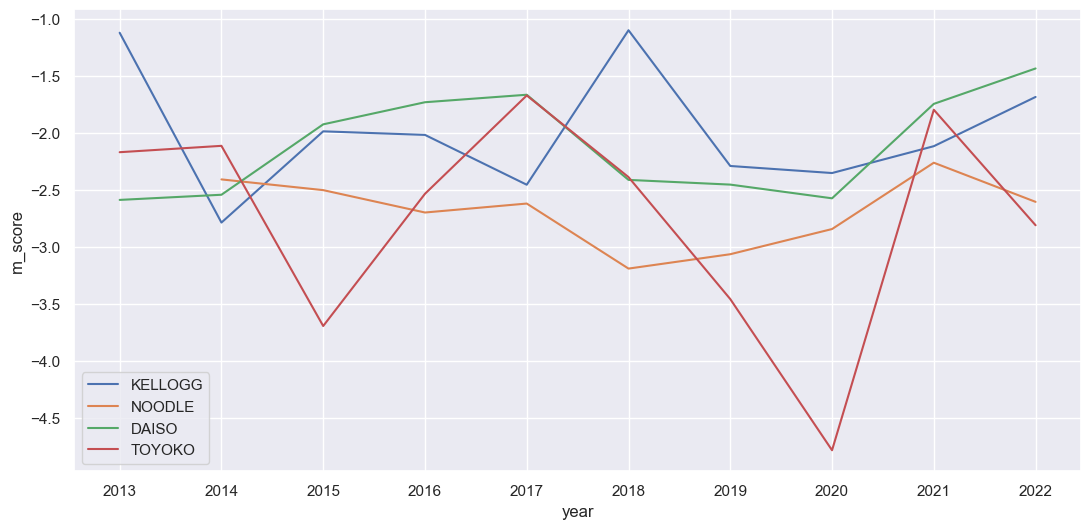

In [21]:
# M-score plotting
import matplotlib.pyplot as plt
import seaborn as sns

for i, corp in enumerate(corps):
    df1 = df[df['corp_code']==corp][['year', 'm_score']]
    df1 = df1.sort_values('year', ascending=True)
   
    sns.set(rc = {'figure.figsize':(13,6)})
    df1 = df1.set_index(keys=['year'])
    # print(df1)

    sns.lineplot(data=df1, x='year', y='m_score', label=target_name(corp))
    plt.legend()    

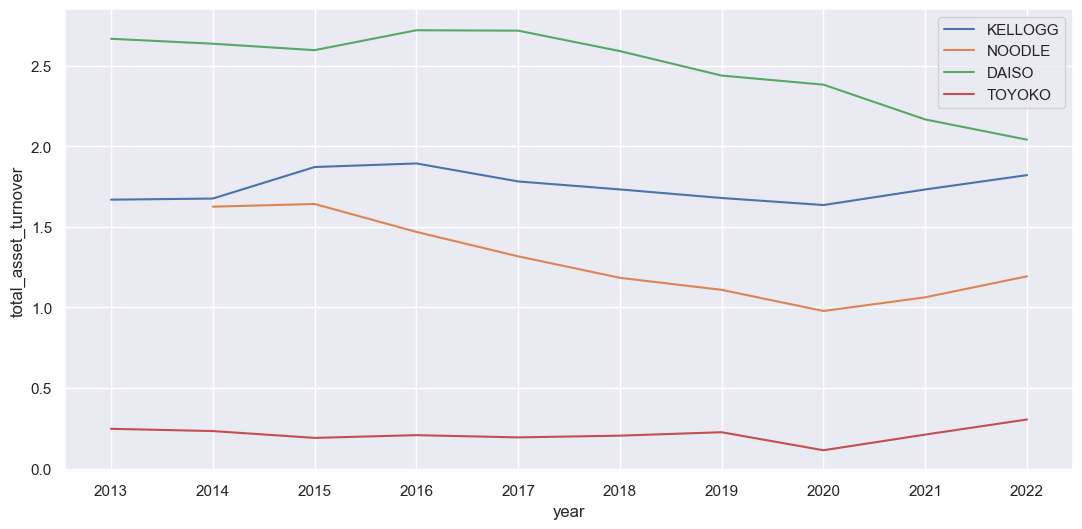

In [22]:
# activity ratios
import matplotlib.pyplot as plt

for i, corp in enumerate(corps):
    df1 = df[df['corp_code']==corp][['year', 'total_asset_turnover']]
    df1 = df1.sort_values('year', ascending=True)

    sns.set(rc = {'figure.figsize':(13,6)})
    df1 = df1.set_index(keys=['year'])
    # print(df1)

    sns.lineplot(data=df1, x='year', y='total_asset_turnover', label=target_name(corp))   
    plt.legend()    

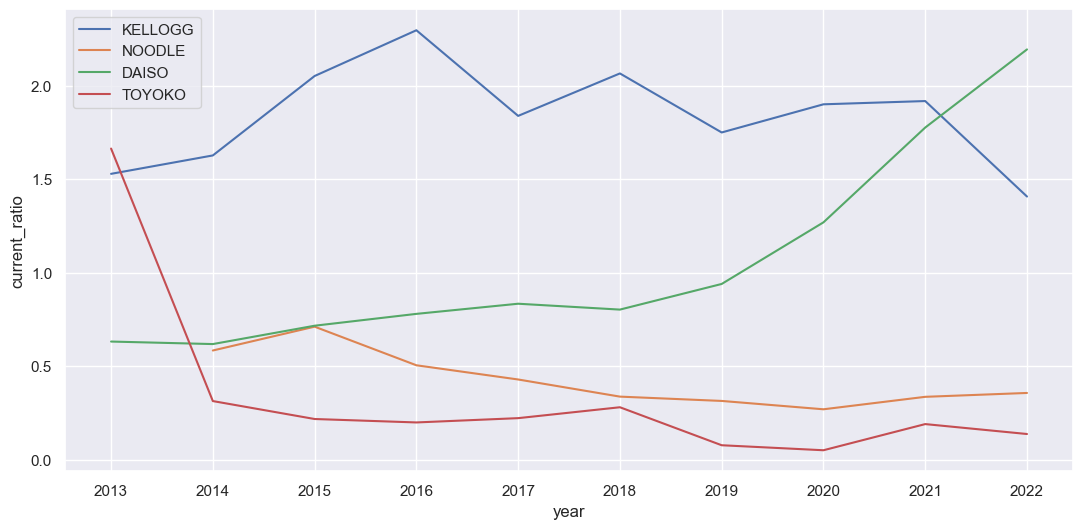

In [23]:
# liquidity ratios
import matplotlib.pyplot as plt

for i, corp in enumerate(corps):
    df1 = df[df['corp_code']==corp][['year', 'current_ratio']]
            # 'current_ratio', 'quick_ratio', 'cash_ratio']]
    df1 = df1.sort_values('year', ascending=True)
    
    sns.set(rc = {'figure.figsize':(13,6)})
    df1 = df1.set_index(keys=['year'])
    # print(df1)

    sns.lineplot(data=df1, x='year', y='current_ratio', label=target_name(corp))   
    plt.legend()

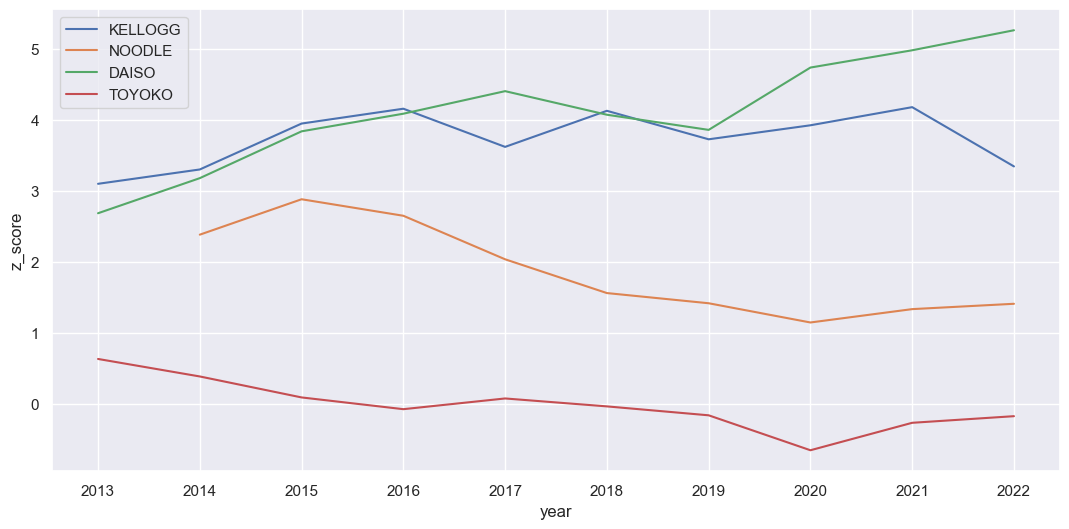

In [24]:
# z-score
import matplotlib.pyplot as plt

for i, corp in enumerate(corps):
    df1 = df[df['corp_code']==corp][['year', 'z_score']]
    df1 = df1.sort_values('year', ascending=True)
   
    sns.set(rc = {'figure.figsize':(13,6)})
    df1 = df1.set_index(keys=['year'])
    # print(df1)

    sns.lineplot(data=df1, x='year', y='z_score', label=target_name(corp))    
    plt.legend()

## 7. 기업가치평가 시뮬레이션(DCF)

기업가치평가법의 3가지 대분류

* 자산가치법(asset approach): 청산가치, 보통 자산/부채 실사를 통한 조정 
* 수익가치법(income approach): 계속기업가치, Free cash flow(FCFF or FCFE) based DCF
* 상대가치법(market approach): EV/EBITDA, P/E, P/B, P/S 등

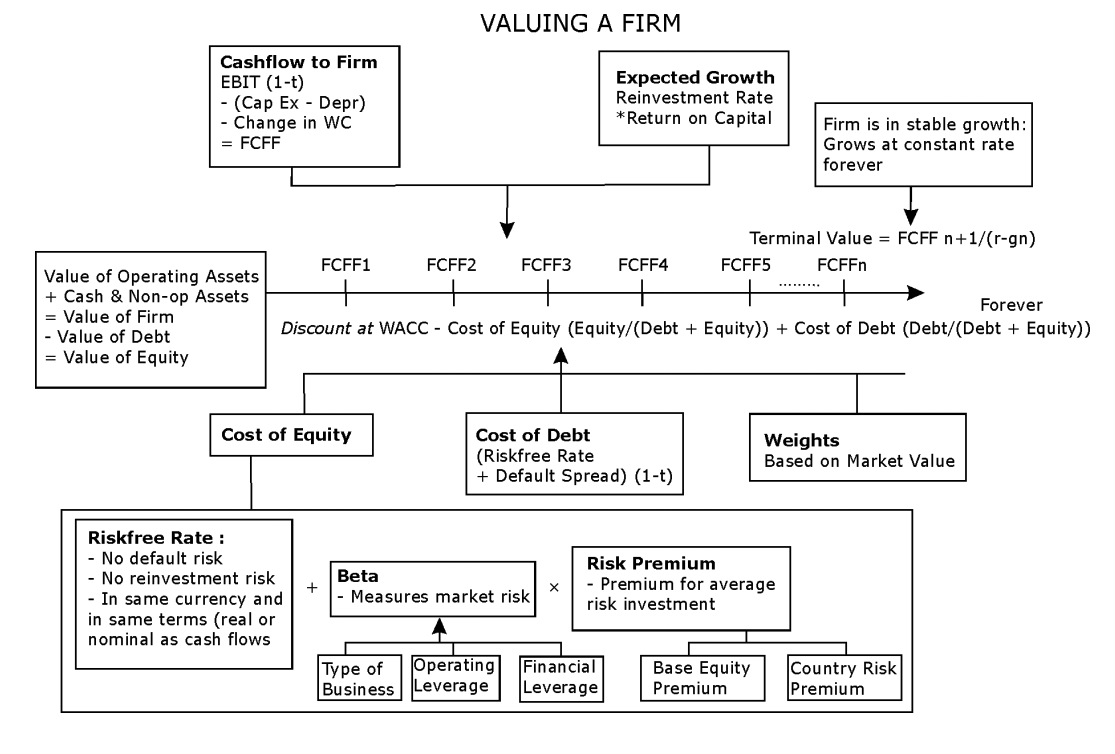

In [25]:
def acct_series(df, acct):
    temp = (df['acct_nm'] == acct[0])
    for idx in range(len(acct)):
        if idx > 0:
            temp = temp | (df['acct_nm'] == acct[idx])    
      
    # print(df.loc[temp].groupby(['year']).sum())
    return df.loc[temp].groupby(['year']).sum().amt

In [38]:
# DCF + Monte Carlo Simulation
import numpy as np
import pandas as pd
import seaborn as sns

BASE_YEAR = '2022' # last year

df_report = select_query("select distinct corp_code, year, month from REPORT where month=acc_mt and year=" + BASE_YEAR)
# df_report = df_report[(df_report['corp_code']==DAISO) | (df_report['corp_code']==TOYOKO)]
# df_report = df_report.query('corp_code == "00301477"')
# print(df_report)
df_comp = select_query("select * from COMPANY")

cols = ['corp_code', 'year', 'month', 'base_sales', 'sales_growth', 'ebit_margin_mu', 'ebit_margin_std',
        'depr_percent_mu', 'depr_percent_std', 'nwc_percent_mu', 'nwc_percent_std', 'capex_percent_mu', 'capex_percent_std',
        'tax_rate', 'wacc', 'mu', 'std']  
rows = []

SALES = ['매출액','영업수익']
DNA = ['감가상각비', '감가상각액', '무형자산상각액']
NON_CASH_CHARGE = DNA + ['대손충당금']
TAX = ['법인세','법인세비용']
CAPEX = ['유형자산의취득','기계장치의취득','토지의취득','건물의취득','차량운반구의취득','의료장비의취득','비품의취득', \
         '시설장치의취득','건설중인자산의취득','상표권의취득']

iterations = 2000

for i, r in df_report.iterrows():    
    
    results = []
       
    print(r['corp_code'], r['year'], r['month'])
    
    df = select_query("select * from FS where corp_code='"+r['corp_code']+"' and year <= '"+r['year']+"' \
            and month='"+r['month']+"'")
    df = df.sort_values(by='year', ascending=True)
    # print(df)
       
    if len(df) <= 0:
        continue
    else:
        corp_code = r['corp_code']
        year = r['year']
        month = r['month']        
# 
#     get DCF value by Monte-Carlo simulation 
# 
    base_sales = acct_val(df[df['year']==BASE_YEAR], SALES, 0)
    sales_growth = round(np.mean(acct_series(df,SALES).pct_change()),4) * 0.75 # 성숙기업 sales 안정화 반영
    ebit_margin_mu = round(np.mean(acct_series(df,['영업이익'])/acct_series(df,SALES)),4)
    ebit_margin_std = round(np.std(acct_series(df,['영업이익'])/acct_series(df,SALES)),4)
    depr_percent_mu = round(np.mean(acct_series(df,DNA)/acct_series(df,SALES)),4)
    depr_percent_std = round(np.std(acct_series(df,DNA)/acct_series(df,SALES)),4)
    nwc_percent_mu = round(np.mean((acct_series(df,['유동자산'])-acct_series(df,['유동부채']))/acct_series(df,SALES)),4)
    nwc_percent_std = round(np.std((acct_series(df,['유동자산'])-acct_series(df,['유동부채']))/acct_series(df,SALES)),4)     
    capex_percent_mu = round(np.mean(acct_series(df,CAPEX)/acct_series(df,SALES)),4) * 0.75 # 성숙기업 capex 안정화 반영
    capex_percent_std = round(np.std(acct_series(df,CAPEX)/acct_series(df,SALES)),4) * 0.75 # 성숙기업 capex 안정화 반영
    
    try:    
        if acct_series(df,['영업이익']).iloc[-1] <= 200000000: # 2억원 이하 10%(11%)        
            tax_rate = 0.10
        elif acct_series(df,['영업이익']).iloc[-1] <= 20000000000: # 2억원 초과 200억원 이하 20%(22%)
            tax_rate = (acct_series(df,['영업이익']).iloc[-1] * 0.20 - 20000000) / acct_series(df,['영업이익']).iloc[-1]
        elif acct_series(df,['영업이익']).iloc[-1] < 300000000000: # 200억원 초과 3000억원 이하 22%(24.2%)
            tax_rate = (acct_series(df,['영업이익']).iloc[-1] * 0.22 - 420000000) / acct_series(df,['영업이익']).iloc[-1]
        elif acct_series(df,['영업이익']).iloc[-1] >= 300000000000: # 3000억원 초과 25%(27.5%)
            tax_rate = (acct_series(df,['영업이익']).iloc[-1] * 0.25 - 9420000000) / acct_series(df,['영업이익']).iloc[-1]        
    except: tax_rate = 0.20
    else: tax_rate = round(tax_rate, 4)   
    
    tax_rate = tax_rate * 1.1 # 지방소득세 10% 가산
    # (참고) 법인세 세율이 과세표준 구간별로 1%씩 인하(2023. 1. 1. 이후 개시하는 사업연도부터 적용)     
        
    # WACC 계산                         
    r_e = 0.10
    r_d = 0.06
    wacc = r_d * (1-tax_rate) * 0.5 + r_e * 0.5       
    
    # Create probability distributions
    ebit_margin_dist = np.random.normal(loc=ebit_margin_mu, scale=ebit_margin_std, size=iterations)
    depr_percent_dist = np.random.normal(loc=depr_percent_mu, scale=depr_percent_std, size=iterations)
    nwc_percent_dist = np.random.normal(loc=nwc_percent_mu, scale=nwc_percent_std, size=iterations)    
    capex_percent_dist = np.random.normal(loc=capex_percent_mu, scale=capex_percent_std, size=iterations)
    
    # Calculate DCF value for each set of random inputs
    output_dist = []
    sales = pd.Series(0)    
    
    ## MC simulation
    for i in range(iterations):
        
        sales[0] = acct_val(df[df['year']==BASE_YEAR], SALES, 0)

        for y in range(1, 6):
            sales[y] = sales[y-1] * (1 + sales_growth)

        ebit = sales * ebit_margin_dist[i]
        depr = sales * depr_percent_dist[i]        
        nwc = sales * nwc_percent_dist[i]
        change_in_nwc = nwc - nwc.shift(1)
        capex = sales * capex_percent_dist[i]     
        free_cash_flow = ebit*(1-tax_rate) + depr - capex - change_in_nwc
        
        # DCF valuation
        terminal_value = (free_cash_flow.iloc[-1] * 1.02) / (wacc - 0.02)
        free_cash_flow.iloc[-1] += terminal_value
        discount_factors = [(1 / (1 + wacc)) ** i for i in range (1,6)]
        dcf_value = sum(free_cash_flow[1:] * discount_factors)
        output_dist.append(dcf_value)
    
    mu = round(np.mean(output_dist))
    std = round(np.std(output_dist))    
    
    results.extend([globals()[cols[i]] for i, _ in enumerate(cols)])      
    rows.append({cols[i]:results[i] for i, _ in enumerate(cols)})
             
df = pd.DataFrame(rows, columns=cols)
save_to_table(df, 'DCF')

00108269 2022 12
00301477 2022 12
00411835 2022 12
00585583 2022 12


In [466]:
df.to_excel('DCF.xlsx')

<Axes: ylabel='Density'>

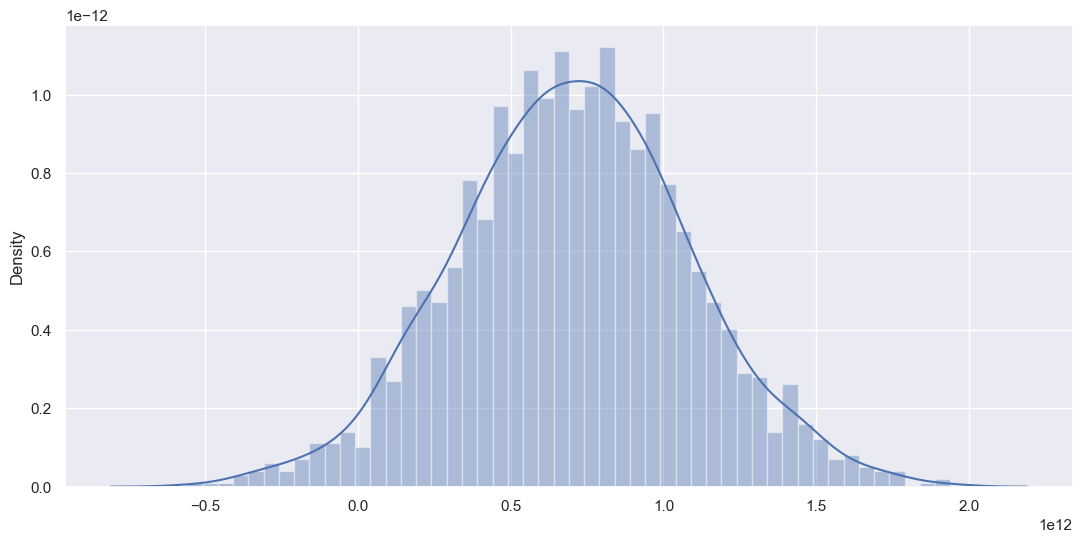

In [29]:
# 확률밀도함수(KDE)
sns.set(rc = {'figure.figsize':(13,6)})
sns.distplot(output_dist, bins=50)

In [39]:
# pro-forma financial statement
def make_fs_estimated(corp_code):    
    import pandas as pd
    
    SALES = ['매출액','수익(매출액)','영업수익']
    EBIT = ['영업이익']
    DNA = ['감가상각비', '감가상각액', '무형자산상각비','무형자산상각액']
    CAPEX = ['유형자산의취득','기계장치의취득','토지의취득','건물의취득','차량운반구의취득','의료장비의취득','비품의취득', \
         '시설장치의취득','건설중인자산의취득','상표권의취득']   

    dcf = select_query("select * from DCF where corp_code='" + corp_code + "'")    
    fs = select_query("select * from FS where corp_code='" + corp_code + "'")
    fs = fs.sort_values(by='year', ascending=True)
    # print(dcf)
    
    df = pd.DataFrame()
    
    df['sales'] = acct_series(fs, SALES)
    df['ebit'] = acct_series(fs, EBIT)
    df['depr'] = acct_series(fs, DNA)
    df['nwc'] = acct_series(fs,['유동자산'])-acct_series(fs,['유동부채'])
    df['delta_nwc'] = df['nwc'] - df['nwc'].shift(1)
    df['capex'] = acct_series(fs, CAPEX)
    df = df.fillna(0) # FCFF가 null이 나오는 것을 방지
    df['fcff'] = df['ebit']*(1-dcf.at[0,'tax_rate']) + df['depr'] - df['delta_nwc'] - df['capex']  
    # dataframe.at[] -> 하나의 스칼라 값에만 접근 가능, 속도향상
      
    cols = ['sales','ebit','depr','nwc','delta_nwc','capex','fcff']
    rows = []    
    years = []
    
    print('==========================')
    print('ebit_margin_mu:', dcf.at[0,'ebit_margin_mu'])
    print('depr_percent_mu:', dcf.at[0,'depr_percent_mu'])
    print('nwc_percent_mu:', dcf.at[0,'nwc_percent_mu'])
    print('capex_percent_mu:', dcf.at[0,'capex_percent_mu'])
    print('tax_rate:', dcf.at[0,'tax_rate'])
    print('wacc:', dcf.at[0,'wacc'])    
    print('==========================')
    
    prev_nwc = df.at[df.index[-1], 'nwc'] 
    # print(prev_nwc)
   
    # 5개년 추정재무제표 생성
    for i in range(5):        
        results = []       

        years.append(str(int(df.index[-1])+(i+1)))        
        sales = dcf.at[0,'base_sales'] * (1+dcf.at[0,'sales_growth'])**(i+1)        
        ebit = sales*dcf.at[0,'ebit_margin_mu']
        depr = sales*dcf.at[0,'depr_percent_mu']
        nwc = sales*dcf.at[0,'nwc_percent_mu']
        delta_nwc = nwc - prev_nwc
        capex = sales*dcf.at[0,'capex_percent_mu']
        fcff = sales*dcf.at[0,'ebit_margin_mu']*(1-dcf.at[0,'tax_rate'])+sales*dcf.at[0,'depr_percent_mu']-\
                       (sales*dcf.at[0,'nwc_percent_mu'] - prev_nwc) - sales*dcf.at[0,'capex_percent_mu']
        
        results.extend([sales, ebit, depr, nwc, delta_nwc, capex, fcff])        
        # results.extend([globals()[cols[i]] for i, _ in enumerate(cols)])  
        rows.append({cols[i]:results[i] for i, _ in enumerate(cols)})
        
        prev_nwc = sales*dcf.at[0,'nwc_percent_mu']        
            
    df2 = pd.DataFrame(rows, columns=cols, index=years)        
    df = pd.concat([df, df2])

    return df

In [42]:
pd.options.display.float_format = '{:,.0f}'.format
# pd.reset_option('display.float_format')
df = make_fs_estimated(DAISO)
df = df.fillna(0)
df

ebit_margin_mu: 0.0677
depr_percent_mu: 0.064
nwc_percent_mu: -0.0001
capex_percent_mu: 0.03195
tax_rate: 0.24002
wacc: 0.0727994


,sales,ebit,depr,nwc,delta_nwc,capex,fcff
2013,"746,512,962,345","-2,560,687,788","71,714,024,918","-68,827,968,366",0,"16,072,373,178","53,695,580,235"
2014,"890,045,251,414","56,234,525,127","62,114,394,486","-75,741,791,837","-6,913,823,471","119,680,945,244","-7,915,612,881"
2015,"1,049,335,923,632","84,299,372,762","61,972,694,262","-61,013,881,693","14,727,910,144","27,275,822,669","84,034,798,761"
2016,"1,305,583,763,484","113,132,430,609","79,228,041,452","-52,486,881,439","8,527,000,254","48,287,212,794","108,392,213,018"
2017,"1,645,748,969,803","149,798,699,791","111,766,717,438","-46,885,062,404","5,601,819,035","72,954,825,957","147,054,088,313"
2018,"1,978,571,938,775","125,134,073,336","147,525,146,842","-66,704,893,598","-19,819,831,194","89,757,009,842","172,687,361,248"
2019,"2,236,209,030,402","76,664,409,802","181,750,364,588","-19,464,789,345","47,240,104,253","169,231,767,071","23,541,911,425"
2020,"2,421,572,355,360","173,757,214,226","173,330,857,384","92,606,180,016","112,070,969,361","46,660,960,181","146,650,935,509"
2021,"2,604,842,338,168","283,834,599,253","131,860,034,534","343,332,632,745","250,726,452,729","18,250,084,951","78,592,115,594"
2022,"2,945,760,870,659","239,343,277,089","105,754,750,002","517,442,342,370","174,109,709,625","45,090,751,662","68,450,392,437"


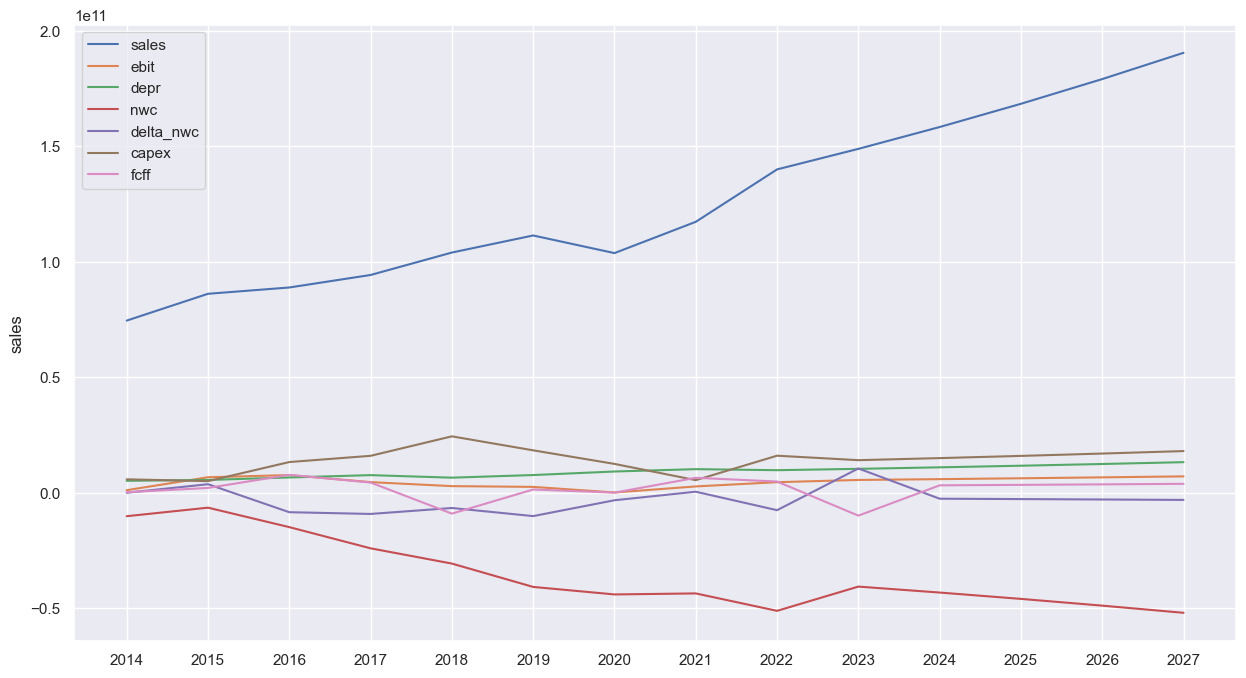

In [41]:
import matplotlib.pyplot as plt
 
sns.set(rc = {'figure.figsize':(15,8)})

for col in df.columns[0:]:
    sns.lineplot(data=df, x=df.index, y=col, label=col)    
    plt.legend()
    # plt.ticklabel_format(style='plain', axis='y')

## [Quiz 4]

* DuPont analysis

ROE = net_profit_margin * total_asset_turnover * financial_leverage

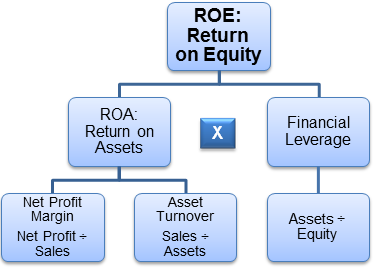

1. 전체 3개 기업에 대하여 2022년 ROE를 듀퐁분석해서 마크다운 표로 나타내 보세요.

기업명 | ROE | 순이익률 | 총자산회전율 | 재무레버리지
----- | -----| --------| ------------| -----------
농심켈로그 | 0.4147 | 0.1237 |  1.8213 | 1.8409
면사랑    |        |        |         |
아성다이소 |        |        |         |
토요코인  |        |        |         |

2. 위에서 구한 표를 seaborn.lineplot()으로 한 화면에 그래프로 표시해 보세요.

select corp_name, return_on_equity, net_profit_margin, total_asset_turnover, financial_leverage from ANLS where year='2022'

df = select_query()

